In [1]:
from cnn.model import build_net

from spleen_dataset.dataloader import SpleenDataloader, SpleenDataset, get_training_augmentation, get_validation_augmentation
from spleen_dataset.config import dataset_folder
from spleen_dataset.utils import get_split_deterministic, get_list_of_patients

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
import matplotlib.pyplot as plt
import random
import numpy as np

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    #tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6400)])
    tf.config.experimental.set_memory_growth(gpus[0], False)
  except RuntimeError as e:
    print(e)

2022-09-24 15:56:36.876930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-24 15:56:36.944383: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-24 15:56:36.944576: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
patients = get_list_of_patients(dataset_folder)

In [3]:
patch_size = (128, 128)
batch_size = 32
num_classes = 2
train_augmentation = get_training_augmentation(patch_size)
val_augmentation = get_validation_augmentation(patch_size)

net_list = [ 
    'vgg_3_64',
    'vgg_3_128',
    'vgg_3_256',
    'vgg_3_512',
    'vgg_3_1024',
    'vgg_3_512',
    'vgg_3_256',
    'vgg_3_128',
    'vgg_3_64',
]


fn_dict = {
    'vgg_3_32':       {'block': 'VGGBlock',      'params': {'kernel': 3, 'filters': 32},   'prob': 1/36},
    'vgg_3_64':       {'block': 'VGGBlock',      'params': {'kernel': 3, 'filters': 64},   'prob': 1/36},
    'vgg_3_128':      {'block': 'VGGBlock',      'params': {'kernel': 3, 'filters': 128},  'prob': 1/36},
    'vgg_3_256':      {'block': 'VGGBlock',      'params': {'kernel': 3, 'filters': 256},  'prob': 1/36},
    'vgg_3_512':      {'block': 'VGGBlock',      'params': {'kernel': 3, 'filters': 512},  'prob': 1/36},
    'vgg_3_1024':     {'block': 'VGGBlock',      'params': {'kernel': 3, 'filters': 1024}, 'prob': 1/36},
    # 'resnet_3_32':    {'block': 'ResNetBlock',   'params': {'kernel': 3, 'filters': 32},   'prob': 1/36},
    # 'resnet_3_64':    {'block': 'ResNetBlock',   'params': {'kernel': 3, 'filters': 64},   'prob': 1/36},
    # 'resnet_3_128':   {'block': 'ResNetBlock',   'params': {'kernel': 3, 'filters': 128},  'prob': 1/36},
    # 'resnet_3_256':   {'block': 'ResNetBlock',   'params': {'kernel': 3, 'filters': 256},  'prob': 1/36},
    # 'resnet_3_512':   {'block': 'ResNetBlock',   'params': {'kernel': 3, 'filters': 512},  'prob': 1/36},
    # 'xception_3_32':  {'block': 'XceptionBlock', 'params': {'kernel': 3, 'filters': 32},   'prob': 1/36},
    # 'xception_3_64':  {'block': 'XceptionBlock', 'params': {'kernel': 3, 'filters': 64},   'prob': 1/36},
    # 'xception_3_128': {'block': 'XceptionBlock', 'params': {'kernel': 3, 'filters': 128},  'prob': 1/36},
    # 'xception_3_256': {'block': 'XceptionBlock', 'params': {'kernel': 3, 'filters': 256},  'prob': 1/36},
    # 'xception_3_512': {'block': 'XceptionBlock', 'params': {'kernel': 3, 'filters': 512},  'prob': 1/36},
    # 'mbconv_3_32':    {'block': 'MBConvBlock',   'params': {'kernel': 3, 'filters': 32},   'prob': 1/36},
    # 'mbconv_3_64':    {'block': 'MBConvBlock',   'params': {'kernel': 3, 'filters': 64},   'prob': 1/36},
    # 'mbconv_3_128':   {'block': 'MBConvBlock',   'params': {'kernel': 3, 'filters': 128},  'prob': 1/36},
    # 'mbconv_3_256':   {'block': 'MBConvBlock',   'params': {'kernel': 3, 'filters': 256},  'prob': 1/36},
    # 'mbconv_3_512':   {'block': 'MBConvBlock',   'params': {'kernel': 3, 'filters': 512},  'prob': 1/36},
}

/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


2022-09-24 15:57:02.002427: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-24 15:57:02.003737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-24 15:57:02.003969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-24 15:57:02.004059: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

[0.9272143840789795, 0.9258408546447754, 0.9371681809425354, 0.936443030834198, 0.9391070008277893, 0.9275206923484802, 0.9402841925621033, 0.9402000904083252, 0.9383504986763, 0.9367918372154236]


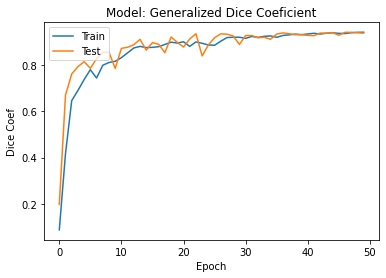

[0.9044201970100403, 0.9250466823577881, 0.9196779131889343, 0.9135687351226807, 0.9153702259063721, 0.9207146167755127, 0.9191455841064453, 0.9180557131767273, 0.9195161461830139, 0.916451632976532]


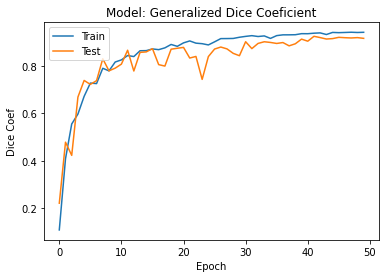

[0.9353147745132446, 0.9291612505912781, 0.9358099102973938, 0.9322129487991333, 0.9319474101066589, 0.9312713146209717, 0.930980384349823, 0.9324754476547241, 0.9324003458023071, 0.9310916662216187]


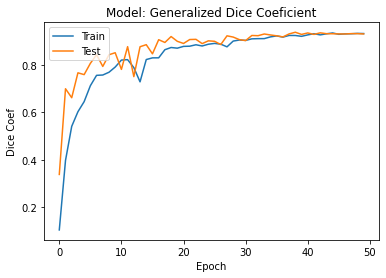

KeyboardInterrupt: 

In [4]:
val_gen_dice_coef_list = []
num_splits = 5
num_initializations = 3
epochs = 50
evaluation_epochs = int(0.2 * epochs)

for initialization in range(num_initializations):

    for fold in range(num_splits):
        train_patients, val_patients = get_split_deterministic(patients, fold=fold, num_splits=num_splits, random_state=initialization)

        train_dataset = SpleenDataset(train_patients, only_non_empty_slices=True)
        val_dataset = SpleenDataset(val_patients, only_non_empty_slices=True)

        train_dataloader = SpleenDataloader(train_dataset, batch_size, train_augmentation)
        val_dataloader = SpleenDataloader(val_dataset, batch_size, val_augmentation)

        model = build_net((*patch_size, 1), num_classes, fn_dict, net_list)

        # checkpoint_filepath = '/tmp/checkpoint'
        # model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        #     filepath=checkpoint_filepath,
        #     save_weights_only=True,
        #     monitor='val_gen_dice_coef',
        #     mode='max',
        #     save_best_only=True)

        # def learning_rate_fn(epoch, lr):
        #     return lr * 0.9

        # learning_rate_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(learning_rate_fn)

        def learning_rate_fn(epoch):
            initial_lr = 1e-3
            power = 0.9
            return float(initial_lr * (1 - (epoch / float(epochs))) ** power)
            
        lr_callback = tf.keras.callbacks.LearningRateScheduler(learning_rate_fn, verbose=False)

        history = model.fit(
            train_dataloader,
            validation_data=val_dataloader,
            epochs=epochs,
            verbose=0,
            callbacks=[
                lr_callback
                #model_checkpoint_callback,
                # learning_rate_scheduler_callback
            ]
        )
        
        # model.load_weights(checkpoint_filepath)

        print(history.history['val_gen_dice_coef'][-evaluation_epochs:])

        val_gen_dice_coef_list.extend(history.history['val_gen_dice_coef'][-evaluation_epochs:])

        # for patient in val_patients:
        #     patient_dataset = SpleenDataset([patient], only_non_empty_slices=True)
        #     patient_dataloader = SpleenDataloader(patient_dataset, 1, val_augmentation, shuffle=False)
        #     results = model.evaluate(patient_dataloader)
        #     val_gen_dice_coef_patient = results[-1]
        #     val_gen_dice_coef_list.append(val_gen_dice_coef_patient)

        #plotting the dice coef results (accuracy) as a function of the number of epochs
        plt.figure()
        plt.plot(history.history['gen_dice_coef'])
        plt.plot(history.history['val_gen_dice_coef'])
        plt.title('Model: Generalized Dice Coeficient')
        plt.ylabel('Dice Coef')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        #plotting the dice coeff results (loss function) as a function of the number of epochs
        # plt.figure()
        # plt.plot(history.history['loss'])
        # plt.plot(history.history['val_loss'])
        # plt.title('Model: Generalized Dice Coeficient')
        # plt.ylabel('Dice Loss')
        # plt.xlabel('Epoch')
        # plt.legend(['Train', 'Test'], loc='upper right')
        # plt.show()

mean_val_gen_dice_coef = (np.mean(val_gen_dice_coef_list))
std_val_gen_dice_coef = (np.std(val_gen_dice_coef_list))

print(f'Dice {mean_val_gen_dice_coef} +- {std_val_gen_dice_coef}')

In [ ]:
#!tensorboard --logdir='./logs'